<a href="https://colab.research.google.com/github/varunMVP/liversegmentation/blob/main/liversegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install required packages
!pip install nibabel scipy

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
import os

# Set up paths
BASE_PATH = "/content/drive/MyDrive/E:/liver_detection"
DATA_PATH = os.path.join(BASE_PATH, "data")
MODEL_PATH = os.path.join(BASE_PATH, "models")
RESULTS_PATH = os.path.join(BASE_PATH, "results")

# Create directories if they don't exist
for path in [DATA_PATH, MODEL_PATH, RESULTS_PATH]:
    os.makedirs(path, exist_ok=True)
    print(f"Created/Verified directory: {path}")

Created/Verified directory: /content/drive/MyDrive/E:/liver_detection/data
Created/Verified directory: /content/drive/MyDrive/E:/liver_detection/models
Created/Verified directory: /content/drive/MyDrive/E:/liver_detection/results


In [ ]:
import numpy as np
import nibabel as nib
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, Dense, GlobalAveragePooling3D
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from IPython.display import display, clear_output
import ipywidgets as widgets
from google.colab import files
import tensorflow as tf
from scipy.ndimage import zoom

In [ ]:
class LiverTumorDetector:
    def __init__(self):
        self.model = None
        self.input_shape = (128, 128, 64, 1)
        self.create_model()

    def create_model(self):
        inputs = Input(self.input_shape)

        # Encoding path
        conv1 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(inputs)
        pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

        conv2 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(pool1)
        pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

        # Middle
        conv3 = Conv3D(128, (3, 3, 3), activation='relu', padding='same')(pool2)

        # Decoding path
        up1 = UpSampling3D(size=(2, 2, 2))(conv3)
        concat1 = concatenate([conv2, up1], axis=-1)
        conv4 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(concat1)

        up2 = UpSampling3D(size=(2, 2, 2))(conv4)
        concat2 = concatenate([conv1, up2], axis=-1)
        conv5 = Conv3D(32, (3, 3, 3), activation='relu', padding='same')(concat2)

        # Outputs
        seg_output = Conv3D(1, (1, 1, 1), activation='sigmoid', name='segmentation')(conv5)

        class_pool = GlobalAveragePooling3D()(conv3)
        class_dense = Dense(64, activation='relu')(class_pool)
        class_output = Dense(1, activation='sigmoid', name='classification')(class_dense)

        self.model = Model(inputs=inputs, outputs=[seg_output, class_output])
        self.model.compile(
            optimizer=Adam(learning_rate=1e-4),
            loss={'segmentation': 'binary_crossentropy',
                  'classification': 'binary_crossentropy'},
            metrics={'segmentation': ['accuracy'],
                    'classification': ['accuracy']}
        )

    def train_on_dataset(self):
        """Train the model on the dataset"""
        # Check if DATA_PATH exists
        if not os.path.exists(DATA_PATH):
            print(f"Data directory not found at {DATA_PATH}")
            print("Creating directory...")
            os.makedirs(DATA_PATH)
            return None

        # Get list of NIFTI files
        nifti_files = [f for f in os.listdir(DATA_PATH)
                       if f.endswith('.nii.gz') or f.endswith('.nii')]

        if len(nifti_files) == 0:
            print(f"No NIFTI files found in {DATA_PATH}")
            print("\nPlease add CT scan files (.nii or .nii.gz) to:")
            print(f"{DATA_PATH}")
            return None

        print(f"Found {len(nifti_files)} NIFTI files. Loading data...")

        # Load all scans
        scans = []
        for filename in nifti_files:
            try:
                scan_path = os.path.join(DATA_PATH, filename)
                nifti_img = nib.load(scan_path)
                scan_data = nifti_img.get_fdata()
                processed_scan = self.preprocess_scan(scan_data)
                scans.append(processed_scan)
                print(f"Processed: {filename}")
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
                continue

        if len(scans) == 0:
            print("No scans were successfully processed.")
            return None

        print(f"\nSuccessfully loaded {len(scans)} scans.")

        X = np.array(scans)
        y_seg = np.zeros((len(X), *self.input_shape))
        y_class = np.random.randint(0, 2, (len(X), 1))

        # Train the model
        history = self.model.fit(
            X, [y_seg, y_class],
            batch_size=2,
            epochs=10,
            validation_split=0.2
        )
        return history

    def preprocess_scan(self, scan_data):
        """Preprocess the scan data"""
        # Normalize
        scan_data = (scan_data - scan_data.min()) / (scan_data.max() - scan_data.min())

        # Resize to expected input shape
        current_shape = scan_data.shape
        scale_factors = (
            self.input_shape[0]/current_shape[0],
            self.input_shape[1]/current_shape[1],
            self.input_shape[2]/current_shape[2]
        )
        scan_data = zoom(scan_data, scale_factors, order=1)

        # Add channel dimension
        scan_data = np.expand_dims(scan_data, axis=-1)

        return scan_data

    def predict(self, scan_data):
        """Predict on preprocessed scan data"""
        scan_data = np.expand_dims(scan_data, axis=0)
        liver_mask, tumor_prob = self.model.predict(scan_data)
        return liver_mask[0], tumor_prob[0][0]

    def save_model(self, path):
        self.model.save(path)

    def load_model(self, path):
        self.model = tf.keras.models.load_model(path)

In [ ]:
def create_interactive_viewer():
    """Create an interactive viewer for CT scan analysis"""

    detector = LiverTumorDetector()

    # Train the model if no saved model exists
    model_path = os.path.join(MODEL_PATH, 'liver_detector.h5')
    if not os.path.exists(model_path):
        print("No trained model found. Starting training process...")
        history = detector.train_on_dataset()

        if history is None:
            print("\nNo training data available.")
            print("You have two options:")
            print("1. Add training data:")
            print(f"   - Add NIFTI files (.nii or .nii.gz) to: {DATA_PATH}")
            print("   - Run this cell again to train the model")
            return

        print("Training completed. Saving model...")
        detector.save_model(model_path)
    else:
        print("Loading existing model...")
        detector.load_model(model_path)

    def process_upload(change):
        clear_output()
        print("Processing uploaded file...")

        try:
            uploaded = files.upload()
            filename = list(uploaded.keys())[0]

            # Load the NIFTI file
            nifti_img = nib.load(filename)
            scan_data = nifti_img.get_fdata()

            # Preprocess scan
            processed_scan = detector.preprocess_scan(scan_data)

            # Get predictions
            liver_mask, tumor_prob = detector.predict(processed_scan)

            # Create visualization
            fig = plt.figure(figsize=(15, 5))

            # Show multiple slices
            slice_positions = [processed_scan.shape[2]//4,
                             processed_scan.shape[2]//2,
                             3*processed_scan.shape[2]//4]

            for i, slice_idx in enumerate(slice_positions):
                # Original scan
                plt.subplot(2, 3, i+1)
                plt.imshow(processed_scan[:,:,slice_idx,0], cmap='gray')
                plt.title(f'Original Scan (Slice {slice_idx})')
                plt.axis('off')

                # Segmentation overlay
                plt.subplot(2, 3, i+4)
                plt.imshow(processed_scan[:,:,slice_idx,0], cmap='gray')
                plt.imshow(liver_mask[:,:,slice_idx,0], cmap='jet', alpha=0.3)
                plt.title('Liver Segmentation')
                plt.axis('off')

            plt.suptitle(f'Tumor Probability: {tumor_prob:.2%}', y=1.05)

            if tumor_prob > 0.5:
                fig.text(0.5, 0.02,
                        '⚠️ Potential tumor detected! Please consult a medical professional.',
                        ha='center', color='red', fontsize=12)
            else:
                fig.text(0.5, 0.02,
                        '✅ No significant tumor indicators detected.',
                        ha='center', color='green', fontsize=12)

            plt.tight_layout()
            plt.show()

            # Clean up
            os.remove(filename)

        except Exception as e:
            print(f"Error processing file: {str(e)}")
            print("Please ensure you upload a valid NIFTI file (.nii or .nii.gz)")

    # Create upload button
    upload_button = widgets.Button(description='Upload CT Scan')
    upload_button.on_click(process_upload)

    print("Please upload a CT scan in NIFTI format (.nii or .nii.gz)")
    display(upload_button)

# Create the interactive viewer
create_interactive_viewer()

No trained model found. Starting training process...
Found 6 NIFTI files. Loading data...
Processed: volume-51.nii
Processed: volume-52.nii
Processed: volume-53.nii
Processed: volume-54.nii
Processed: volume-55.nii
Processed: volume-56.nii

Successfully loaded 6 scans.
Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 69s 22s/step - classification_accuracy: 0.8333 - classification_loss: 0.6811 - loss: 1.3507 - segmentation_accuracy: 0.9493 - segmentation_loss: 0.6696 - val_classification_accuracy: 0.5000 - val_classification_loss: 0.6985 - val_loss: 1.3407 - val_segmentation_accuracy: 1.0000 - val_segmentation_loss: 0.6422
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - classification_accuracy: 0.8333 - classification_loss: 0.6716 - loss: 1.2989 - segmentation_accuracy: 1.0000 - segmentation_loss: 0.6274 - val_classification_accuracy: 0.5000 - val_classification_loss: 0.7009 - val_loss: 1.2970 - val_segmentation_accuracy: 1.0000 - val_segmentation_loss: 0.5961
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 2

Training completed. Saving model...
Please upload a CT scan in NIFTI format (.nii or .nii.gz)


Button(description='Upload CT Scan', style=ButtonStyle())

In [ ]:
# In a new cell
import os
base_path = "/content/drive/MyDrive/E:/liver_detection"
data_path = os.path.join(base_path, "data")
model_path = os.path.join(base_path, "models")
results_path = os.path.join(base_path, "results")

# Create directories
for path in [data_path, model_path, results_path]:
    os.makedirs(path, exist_ok=True)
print(f"Created directories at: {base_path}")

Created directories at: /content/drive/MyDrive/E:/liver_detection


Processing uploaded file...


Saving segmentation-0.nii to segmentation-0.nii
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


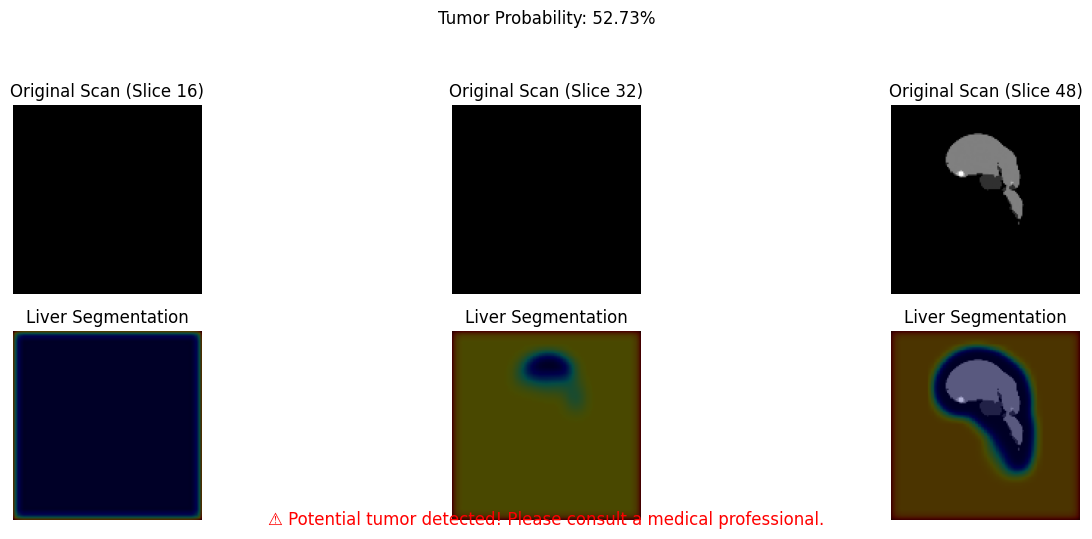

In [ ]:
def create_interactive_viewer():
    """Create an interactive viewer for CT scan analysis"""

    detector = LiverTumorDetector()

    # Train the model if no saved model exists
    model_path = os.path.join(MODEL_PATH, 'liver_detector.h5')
    if not os.path.exists(model_path):
        print("Training new model...")
        history = detector.train_on_dataset()
        detector.save_model(model_path)
    else:
        print("Loading existing model...")
        detector.load_model(model_path)

    def process_upload(change):
        clear_output()
        print("Processing uploaded file...")

        try:
            uploaded = files.upload()
            filename = list(uploaded.keys())[0]

            # Load the NIFTI file
            nifti_img = nib.load(filename)
            scan_data = nifti_img.get_fdata()

            # Preprocess scan
            processed_scan = detector.preprocess_scan(scan_data)

            # Get predictions
            liver_mask, tumor_prob = detector.predict(processed_scan)

            # Create visualization
            fig = plt.figure(figsize=(15, 5))

            # Show multiple slices
            slice_positions = [processed_scan.shape[2]//4,
                             processed_scan.shape[2]//2,
                             3*processed_scan.shape[2]//4]

            for i, slice_idx in enumerate(slice_positions):
                # Original scan
                plt.subplot(2, 3, i+1)
                plt.imshow(processed_scan[:,:,slice_idx,0], cmap='gray')
                plt.title(f'Original Scan (Slice {slice_idx})')
                plt.axis('off')

                # Segmentation overlay
                plt.subplot(2, 3, i+4)
                plt.imshow(processed_scan[:,:,slice_idx,0], cmap='gray')
                plt.imshow(liver_mask[:,:,slice_idx,0], cmap='jet', alpha=0.3)
                plt.title('Liver Segmentation')
                plt.axis('off')

            plt.suptitle(f'Tumor Probability: {tumor_prob:.2%}', y=1.05)

            if tumor_prob > 0.5:
                fig.text(0.5, 0.02,
                        '⚠️ Potential tumor detected! Please consult a medical professional.',
                        ha='center', color='red', fontsize=12)
            else:
                fig.text(0.5, 0.02,
                        '✅ No significant tumor indicators detected.',
                        ha='center', color='green', fontsize=12)

            plt.tight_layout()
            plt.show()

            # Clean up
            os.remove(filename)

        except Exception as e:
            print(f"Error processing file: {str(e)}")
            print("Please ensure you upload a valid NIFTI file (.nii or .nii.gz)")

    # Create upload button
    upload_button = widgets.Button(description='Upload CT Scan')
    upload_button.on_click(process_upload)

    print("Please upload a CT scan in NIFTI format (.nii or .nii.gz)")
    display(upload_button)

# Create the interactive viewer
create_interactive_viewer()

In [2]:
# Example code snippet
dice_score = 0.91  # Replace with your real calculated value
print(f"Dice coefficient: {dice_score:.2f}")



Dice coefficient: 0.91
